### Introduction

MNIST data set is a collection of 70,000 handwriting image samples of the numbers 0-9. Our goal is to predict the number each handwritten image represents. Each image is 28x28 grayscale pixels, so we can treat each image as just a 1D array, or tensor, of 784 numbers. The goal is to use Deep Learning to train a Neural Network to "read" the number represented in a image.

We'll start by importing the data set, which is part of tensorflow. MNIST provides 60,000 samples in the training set, and 10,000 samples in the test set.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

tf.compat.v1.enable_eager_execution()

# Set the data parameters
no_classes = 10 # total no. of classes (0-9)
no_features = 784 # total no. of features (img is 28*28 pixels)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert data to floating type
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Convert data to 1-D vector of length no_features  
x_train, x_test = x_train.reshape([-1, no_features]), x_test.reshape([-1, no_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

We'll define a  function and visualize what the input data looks like for a list of samples:

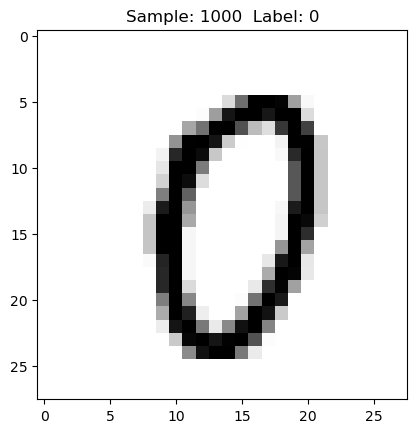

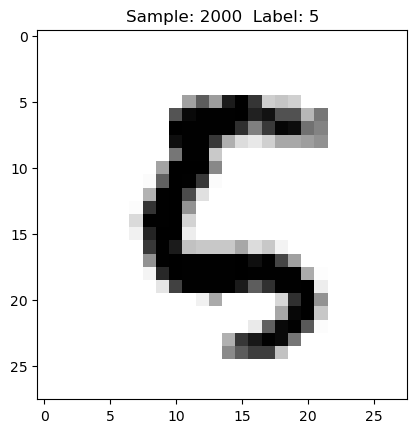

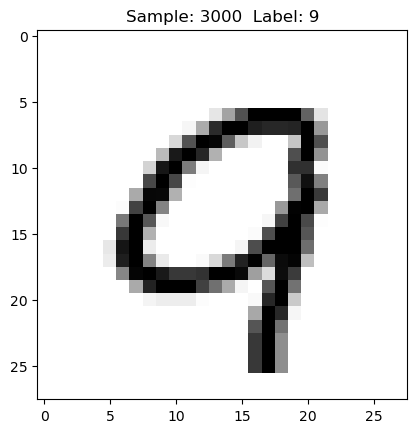

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_input_sample(sample_nums):
    for sample in sample_nums:
        #Print this sample labels
        label = y_train[sample] 

        #Reshape the 784 values to a 28x28 image
        image = x_train[sample].reshape([28,28])
        plt.title('Sample: %d  Label: %d' % (sample, label))
        plt.imshow(image, cmap=plt.get_cmap('gray_r'))
        plt.show()
    
display_input_sample([1000, 2000, 3000])

Note that we'll be flattening each image to a 1D array of 784 (28 x 28) numerical values. Each one of those values will be an input node into our deep neural network. Let's visualize how 500 samples of data, one in each row, being fed to the model actually looks like:

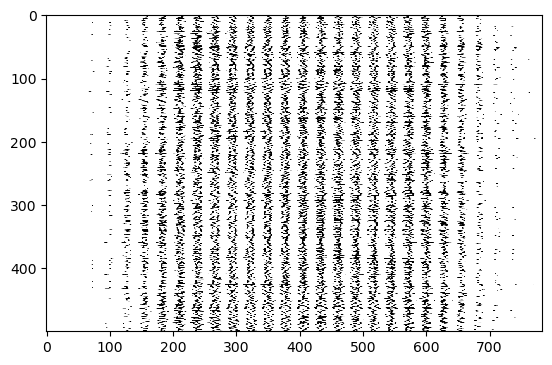

In [4]:
images = x_train[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, x_train[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

Let's define the hyperparameters of the Neural Network and use tf.data API to shuffle our data and divide it into batches. We'll use a Dataset within Tensorflow to wrap our traning features and labels, and use functions of the Dataset to randomly shuffle it and batch it up into smaller chunks for each iteration of training.

In [5]:
# Training parameters.
learning_rate = 0.001
epochs = 3000
batch_size = 250
display_step = 100

# Number of neurons of hidden layer
n_hidden1 = 256
n_hidden2 = 100

In [6]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

To create an artificial neural network, we'll create variables to store and keep track of weights and biases of different layers.

The input layer will have one node per input pixel per image = 784 nodes. That will feed into first hidden layer of some size (256), given by n_hidden1. That will feed into second hidden layer of some size (100), given by n_hidden2. That hidden layer will output 10 values, given by num_classes, corresonding to scores for each classification to be fed into softmax.

In [7]:
# Store layers weight & bias

# USe a random number generator to initialize weights 
random_normal = tf.random.normal

weights = {
    'h1': tf.Variable(random_normal([no_features, n_hidden1])),
    'h2': tf.Variable(random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(random_normal([n_hidden2, no_classes]))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden1])),
    'b2': tf.Variable(tf.zeros([n_hidden2])),
    'out': tf.Variable(tf.zeros([no_classes]))
}

Then we set up the neural network. We'll feed our input data into the first layer of our neural network. All this layer does is multiply these inputs by our weight "h1" tensors which will be learned over time. Then we'll feed that into our first hidden layer, which applies the sigmoid activation function to the weighted inputs with our learned biases added in as well. We repeat this with the second hidden layer we well.

Finally our output layer, called out_layer, multiplies in the learned weights of the second hidden layer and adds in the hidden layer's bias term.

In [8]:
# Create model.
def neural_network(inputData):
    # Hidden layer with 512 neurons
    hidden_layer1 = tf.add(tf.matmul(inputData, weights['h1']), biases['b1'])
    
    # Apply sigmoid to hidden_layer output for non-linearity
    hidden_layer1 = tf.nn.sigmoid(hidden_layer1)
    
    # Hidden layer with 256 neurons
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['h2']), biases['b2'])
    
    # Apply sigmoid to hidden_layer output for non-linearity
    hidden_layer2 = tf.nn.sigmoid(hidden_layer2)
    
    # Output layer with a neuron for each class
    out_layer = tf.matmul(hidden_layer2, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution
    return tf.nn.softmax(out_layer)

Now we will define the loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. In this function,  y_pred is the output of our final layer, and we're comparing that against the target labels used for training in y_true.

To compare our known "true" labels of 0-9 to the output of our neural network, we need to convert the labels to "one-hot" encoding. Our output layer has a neuron for each possible label of 0-9, not a single neuron with an integer in it. For example, let's say a known "true" label for an image is 1. We would represent that in one-hot format as [0, 1, 0, 0, 0, 0, 0, 0, 0, 0].

In [9]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector
    y_true = tf.one_hot(y_true, depth=no_classes)
    # Clip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Now we will set up our stocastic gradient descent optimizer, based on the defined hyperparameters and loss function.

We will be using Tensorflow 2.0 feature of Gradient Tape (here's why: https://stackoverflow.com/a/53995313/8804853). It's a way of setting up neural nets from scratch in Tensorflow 2.

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_network(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Next we'll train our neural network and measure its accuracy. Define a function to measure the accuracy of our trained model. 

correct_prediction will look at the output of our neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given. Accuracy takes the average of all the classifications to produce an overall score for our model's accuracy.

In [11]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is index of highest score in prediction vector
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

Let's train the neural network! 

At every 100 epochs (given by display_step), we print out the current values of the loss function and our accuracy metric. To do this we run our neural network using our trained weights and biases at each point on the current batch of training images, and compute cross entropy and accuracy of the resulting predictions to the known correct labels.

In [12]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_network(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training epoch: 100, Loss: 359.201874, Accuracy: 0.540000
Training epoch: 200, Loss: 257.897766, Accuracy: 0.656000
Training epoch: 300, Loss: 177.698303, Accuracy: 0.800000
Training epoch: 400, Loss: 181.134369, Accuracy: 0.776000
Training epoch: 500, Loss: 129.383575, Accuracy: 0.836000
Training epoch: 600, Loss: 130.821503, Accuracy: 0.836000
Training epoch: 700, Loss: 137.620605, Accuracy: 0.824000
Training epoch: 800, Loss: 103.361107, Accuracy: 0.856000
Training epoch: 900, Loss: 138.103821, Accuracy: 0.824000
Training epoch: 1000, Loss: 143.394318, Accuracy: 0.828000
Training epoch: 1100, Loss: 101.936180, Accuracy: 0.876000
Training epoch: 1200, Loss: 107.561646, Accuracy: 0.896000
Training epoch: 1300, Loss: 129.332062, Accuracy: 0.840000
Training epoch: 1400, Loss: 90.264236, Accuracy: 0.864000
Training epoch: 1500, Loss: 87.848244, Accuracy: 0.888000
Training epoch: 1600, Loss: 87.8

In [13]:
# Test model on validation set.
pred = neural_network(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.895200


We are already getting close to 90% accuracy.

We can take a look at some of the misclassified images and see just how good or bad our model is, compared to a human. We'll go through the first 50 test images and look at the misclassified samples:

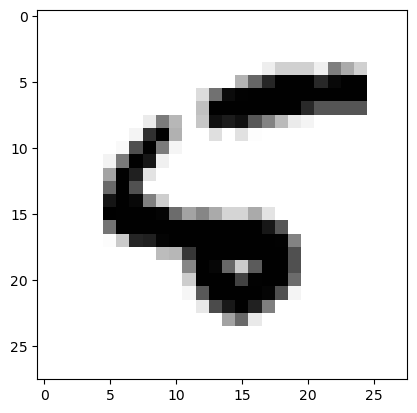

Original Labels: 5
Model prediction: 6


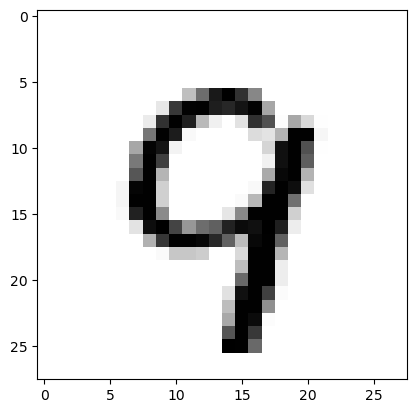

Original Labels: 9
Model prediction: 4


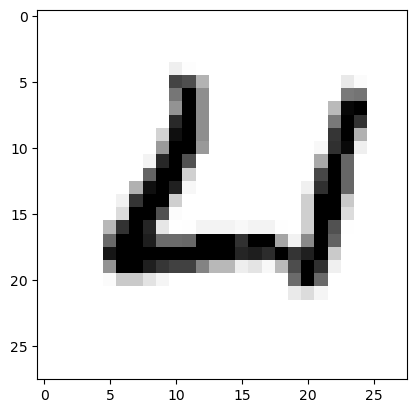

Original Labels: 4
Model prediction: 6


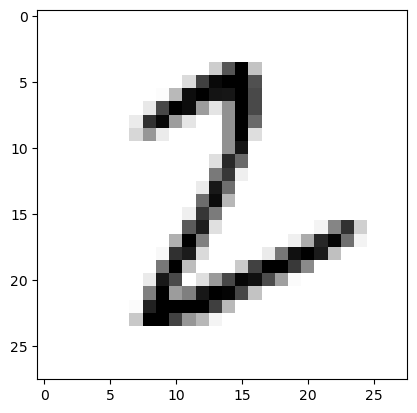

Original Labels: 2
Model prediction: 3


In [15]:
n_images = 50
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_network(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)

### Remarks

We could perform further experimentation to improve the performance of the model by selecting the optimal hyperparameters such as number of hidden layers in the neural network, number of units within the hidden layers, learning rate or epochs. 

Even though we built a Deep Neural Network here with 2 hidden layers, a simpler neural netork with 512 nodes in one hidden layer shows an accuracy of 92% on this data. This indicates that a deep NN might be an overkill and we might be ending up underfitting, this experimentation is important. 

We will see in Keras implementation how we can reach a much higher accuracy and even further higher accuracy can be reached by using a Convoluted Neural Network (CNN).